In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm.auto import tqdm
tqdm.pandas()
import json
import random

import matplotlib.pyplot as plt
from coreLib.segment import *


template_path="image.png"
tem=cv2.imread(template_path)
gmap=gaussian_heatmap(distanceRatio=1.5)
f = open('tem.json')
temdata = json.load(f)
loc_dict={}
for _d in temdata['image.png926838']["regions"]:
    xmin=_d['shape_attributes']['x']
    ymin=_d['shape_attributes']['y']
    xmax=_d['shape_attributes']['width']+xmin
    ymax=_d['shape_attributes']['height']+ymin
    field=_d['region_attributes']['field']
    loc_dict[field]=[xmin,ymin,xmax,ymax]
    
g1=[28,883,28+267,883+177]
g2=[632,886,632+257,886+194]
max_words=3
max_wlen=5
age_boxes=[]
mb_boxes=[]
for k,v in loc_dict.items():
    if "a" in k:
        age_boxes.append(v)
    if "m" in k:
        mb_boxes.append(v)


  0%|          | 0/200840 [00:00<?, ?it/s]

  0%|          | 0/72045 [00:00<?, ?it/s]

  0%|          | 0/46101 [00:00<?, ?it/s]

  0%|          | 0/10305 [00:00<?, ?it/s]

  0%|          | 0/982 [00:00<?, ?it/s]

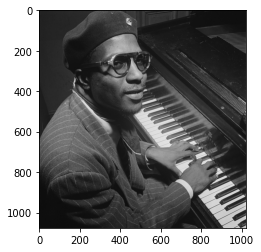

In [2]:
save_dir="/media/ansary/DriveData/Work/APSIS/datasets/CDR/craft/"
img_dir=os.path.join(save_dir,"images")
heat_dir=os.path.join(save_dir,"heats")
link_dir=os.path.join(save_dir,"links")

bn_gdir="/media/ansary/DriveData/Work/APSIS/datasets/Recognition/source/bangla/"
bn_df=pd.read_csv(os.path.join(bn_gdir,"graphemes.csv"))
bn_df.filename=bn_df.filename.progress_apply(lambda x:os.path.join(bn_gdir,"graphemes",f"{x}.bmp"))
bn_comps=bn_df.label.unique()

bn_ndf=pd.read_csv(os.path.join(bn_gdir,"numbers.csv"))
bn_ndf.filename=bn_ndf.filename.progress_apply(lambda x:os.path.join(bn_gdir,"numbers",f"{x}.bmp"))

en_gdir="/media/ansary/DriveData/Work/APSIS/datasets/Recognition/source/english/"
en_df=pd.read_csv(os.path.join(en_gdir,"graphemes.csv"))
en_df.filename=en_df.filename.progress_apply(lambda x:os.path.join(en_gdir,"graphemes",f"{x}.bmp"))
en_comps=en_df.label.unique()

en_ndf=pd.read_csv(os.path.join(en_gdir,"numbers.csv"))
en_ndf.filename=en_ndf.filename.progress_apply(lambda x:os.path.join(en_gdir,"numbers",f"{x}.bmp"))
backs="/media/ansary/DriveData/Work/APSIS/datasets/Recognition/source/common/background/"
backs=[_path for _path in tqdm(glob(os.path.join(backs,"*.*")))]
backgen= backgroundGenerator(backs)
back=next(backgen)
plt.imshow(back)
plt.show()

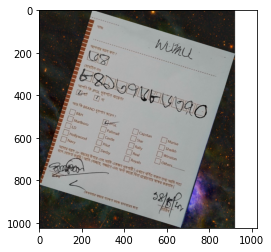

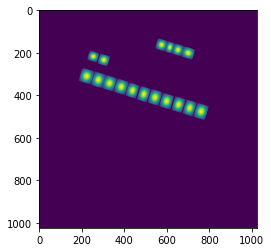

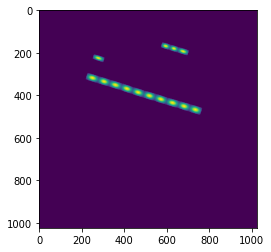

In [4]:
def create_single(dim=(1024,1024)):
    gdf=random.choice([0,0,0,1])
    if gdf==1:
        gdf=en_df
        gcomps=en_comps
    else:
        gdf=bn_df
        gcomps=bn_comps
    img,mask,labels=placeName(2,gdf,gcomps,tem,loc_dict,max_wlen=5)
    heat_mask1,link_mask1=lineTextPage(mask,labels,gmap)
    # garbage
    #img=placeGarbage(img,g1,gdf,gcomps)
    #img=placeGarbage(img,g2,gdf,gcomps)
    
    # numbers
    ndf=random.choice([bn_ndf,en_ndf])
    img=placeNumbers(ndf,mb_boxes,img)
    heat_mask2,link_mask2=lineTextBox(mask,mb_boxes,gmap)
    ndf=random.choice([bn_ndf,en_ndf])
    img=placeNumbers(ndf,age_boxes,img)
    heat_mask3,link_mask3=lineTextBox(mask,age_boxes,gmap)
    heat=heat_mask1+heat_mask2+heat_mask3
    link=link_mask1+link_mask2+link_mask3
    img,heat,link,mask=augment(img,heat,link)
    back=next(backgen)
    h,w,d=img.shape
    back=cv2.resize(back,(w,h))
    back[mask>0]=img[mask>0]
    back=padDetectionImage(back)
    heat=padDetectionImage(heat,gray=True,pad_value=0)
    link=padDetectionImage(link,gray=True,pad_value=0)
    
    back=cv2.resize(back,(dim))
    heat=cv2.resize(heat,(dim),fx=0,fy=0,interpolation = cv2.INTER_NEAREST)
    link=cv2.resize(link,(dim),fx=0,fy=0,interpolation = cv2.INTER_NEAREST)
    return back,heat,link

img,heat,link=create_single()
plt.imshow(img)
plt.show()
plt.imshow(heat)
plt.show()
plt.imshow(link)
plt.show()


In [5]:
for i in tqdm(range(10000)):
    try:
        img,heat,link=create_single()
        cv2.imwrite(os.path.join(img_dir,f"{i}.png"),img)
        cv2.imwrite(os.path.join(heat_dir,f"{i}.png"),heat)
        cv2.imwrite(os.path.join(link_dir,f"{i}.png"),link)
    except Exception as e:
        pass    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
import os
import tensorflow as tf 
from tqdm import tqdm
from glob import glob 
import cv2 
# ---------------------------------------------------------
# globals
# ---------------------------------------------------------
# number of images to store in a tfrecord
DATA_NUM  = 128
#---------------------------------------------------------------
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def to_tfrecord(image_paths,save_dir,r_num):
    '''	            
      Creates tfrecords from Provided Image Paths	        
      args:	        
        image_paths     :   specific number of image paths	       
        save_dir        :   location to save the tfrecords	           
        r_num           :   record number	
    '''
    # record name
    tfrecord_name='{}.tfrecord'.format(r_num)
    # path
    tfrecord_path=os.path.join(save_dir,tfrecord_name)
    with tf.io.TFRecordWriter(tfrecord_path) as writer:    
        for image_path in image_paths:
            
            char_path=str(image_path).replace('images','heats')
            word_path=str(image_path).replace('images','links')
            #image
            with(open(image_path,'rb')) as fid:
                image_bytes=fid.read()
            # char
            with(open(char_path,'rb')) as fid:
                char_bytes=fid.read()
            
            # word
            with(open(word_path,'rb')) as fid:
                word_bytes=fid.read()
            
            
            
            data ={ 'image':_bytes_feature(image_bytes),
                    'heatmap':_bytes_feature(char_bytes),
                    'linkmap':_bytes_feature(word_bytes)
            }
            
            
            
            # write
            features=tf.train.Features(feature=data)
            example= tf.train.Example(features=features)
            serialized=example.SerializeToString()
            writer.write(serialized)


def genTFRecords(_paths,mode_dir):
    '''	        
        tf record wrapper
        args:	        
            _paths    :   all image paths for a mode	        
            mode_dir  :   location to save the tfrecords	    
    '''
    for i in tqdm(range(0,len(_paths),DATA_NUM)):
        # paths
        image_paths= _paths[i:i+DATA_NUM]
        # record num
        r_num=i // DATA_NUM
        # create tfrecord
        to_tfrecord(image_paths,mode_dir,r_num)    





In [7]:
_paths=[img_path for img_path in tqdm(glob(os.path.join(img_dir,"*.*")))]
save_path=os.path.join(save_dir,"tfrecords")
genTFRecords(_paths,save_path)


100%|██████████| 77/77 [09:36<00:00,  7.49s/it]
